In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
# 方法1： 解析式
# 方法2:公式法   对每个节点都可以有: f(x+h)-f(x)/h   这个方法意味着每个节点都要算一次前向传播
# 方法3：链式法则  每个节点的导数由往后的局部导数构成
# 链式法则的反向实现：从最后一个节点开始，向后计算每个节点的梯度，每次backward都替一个运算计算了输入节点的导数

def f(x):
  return 3*x** 2 - 4*x + 5

In [ ]:
a = 2.0
b = -3.0
c = 10.0
d = a*b+c
print(d)


4.0


In [ ]:
# 导数的物理意义：变化率
#指某个节点变化导致最终的结果变化多少的单位量，【导数是速度】

# 导数为2意味着这个节点增加1，最终的结果增加2，增加-0.1，最终的结果增加-0.2
h = 0.00001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b+c
b = b+h
d2 = a*b+c
(d2-d1)/h
# 这玩意很像前向微分，缺点是想算n个节点的导数，需要前向传播n次


2.0000000000131024

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [ ]:
# 引入节点，我们需要：
# 1.给节点引入值，我们需要data
# 2.给节点引入运算，组成计算链
# 3. 保留节点之间的关系， 捕捉计算图
# _prev这个属性当我通过init方法创建的一个Value的时候他是空的，当我通过运算方法创建的时候他应该包含参与运算的节点
# _op这个属性我们需要init方法创建一个Value的时候他是空的，当我通过运算方法创建的的时候特他是得到这个节点的具体的运算
# _label这个属性是给节点命名
# grad这个属性是运算连接的节点中，输入关于输出的导数, 精髓就是这个乘法，你不需要管之后的节点了，你只要✖️输出的梯度(链式法则)
# 所有节点在调用backward之前都有个默认的grad，调用之后会对每个节点计算梯度，帮我们自动实现反向传播
# 调用输出节点的backward方法会对输入节点的grad进行赋值


class Value:
  def __init__(self,data, _children = (), _op = "",label = ""):
    self.data = data
    self.label = label
    self._prev = set(_children)
    self._op = _op
    self.grad = 0.0
    self._backward = lambda:None

  def __repr__(self,):
    return f"Value(data={self.data})"

  def __add__(self,other):
    out_node = Value(self.data + other.data, (self, other),"+")

    def _backward():
      # 求对输入节点的导数
      # 为什么要累加？因为当一个节点重复利用的时候，根据链式法则，梯度需要相加
      self.grad += 1.0 * out_node.grad
      other.grad += 1.0 * out_node.grad
    out_node._bakward = _backward()

    return out_node


  def __mul__(self,other):
    out_node = Value(self.data*other.data, (self, other),"*")

    def _backward():

      self.grad += other.data * out_node.grad
      other.grad += self.data * out_node.grad
    out_node._backward = _backward()

    return out_node

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    print(topo)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [ ]:
a = Value(2.0,label = "a")
b = Value(-3.0,label = "b")
c = Value(10.0,label = "c")
e = a*b;e.label = "e"
d = e+c;e.label = "d"
d._op

'+'

In [ ]:
# 手动反向传播 vs 自动反向传播
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [ ]:
#利用反向传播手算梯度
# grad = 局部梯度*输出节点的梯度
o.grad = 1.0
n.grad = 0.5   # 1-o.data**2
b.grad = 1.0 * 0.5
x1w1x2w2.grad = 1.0*0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad



In [ ]:
draw_dot(o)

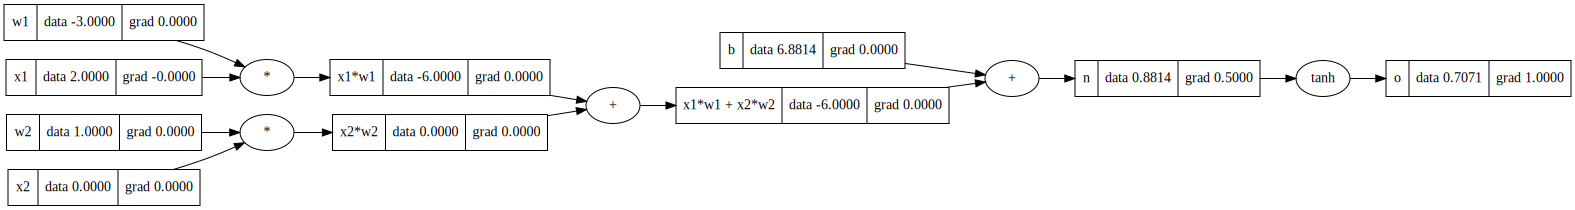

In [ ]:
#利用_backward函数自动计算每个节点的grad=局部梯度*输出节点的梯度
o.grad = 1
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()

In [ ]:
# 利用拓扑排序实现整个图的反向传播
# 只要对最后一个节点进行反向传播即可, 拓扑排序会完成每个节点的遍历
  # def backward(self):

  #   topo = []
  #   visited = set()
  #   def build_topo(v):
  #     if v not in visited:
  #       visited.add(v)
  #       for child in v._prev:
  #         build_topo(child)
  #       topo.append(v)
  #   build_topo(self)

  #   self.grad = 1.0
  #   for node in reversed(topo):
  #     node._backward()
  o

In [ ]:
o.backward()

In [ ]:
#叶子节点的梯度是怎么计算的

In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)